In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [26]:
df = pd.read_csv('AirPassengers.csv')
df.head()

,Month,Passengers
0,15-01-1949,112
1,15-02-1949,118
2,15-03-1949,132
3,15-04-1949,129
4,15-05-1949,121


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [28]:
df.set_index('Month')
df.head()

,Month,Passengers
0,15-01-1949,112
1,15-02-1949,118
2,15-03-1949,132
3,15-04-1949,129
4,15-05-1949,121


## **Visualize the time series**
**Check for trend seasonality or random pattern**

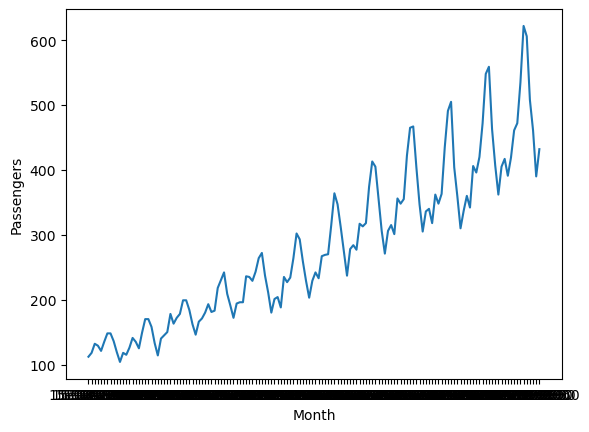

In [42]:
sns.lineplot(x=df['Month'], y=df['Passengers'])
plt.show()

## **Check for stationarity**
**Methid-1 : Rolling Statistics**

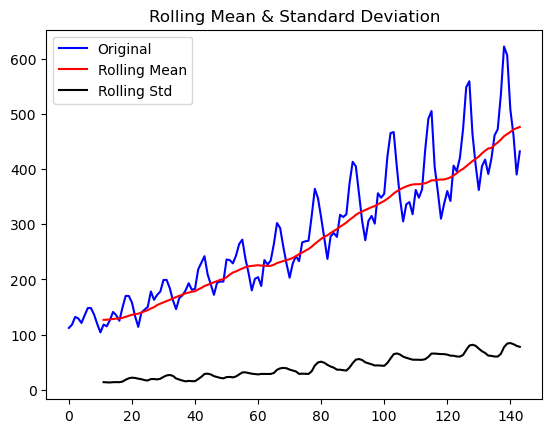

In [43]:
#determing rolling statistics
rolmean = df['Passengers'].rolling(window=12).mean()
rolstd = df['Passengers'].rolling(window=12).std()

#plot rolling stastics:
orig = plt.plot(df['Passengers'], color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std =  plt.plot(rolstd, color='black', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

#### **Methon-2 : Augmented Dicky Fuller Test**

 - for the ADF Test
     1. H0 : Data is non stationary
     2. H1 : Data is stationary
 - Based on pvalue, we will accept or reject H0 (if p-value <5% reject null hypothesis)

In [44]:
from statsmodels.tsa.stattools import adfuller
adfuller_result = adfuller(df['Passengers'])
adfuller_result

(0.8153688792060597,
 0.9918802434376411,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [45]:
print('p-value:', adfuller_result[1])

p-value: 0.9918802434376411


### **The time series is not stationary**
## **Now we have to covert the non-stationary data to stationary data**
**Differencing**

In [46]:
#apply differencing
diff = df['Passengers']- df['Passengers'].shift(2)

diff.dropna(inplace=True)

#aplying ADF Test
adfuller_result = adfuller(diff)
print('p-value of adf test:', adfuller_result[1])

p-value of adf test: 0.038629757676988535


**Now, the time series is stationary**
# Step-4: Plot ACF/PACF and find p,d,q parameters

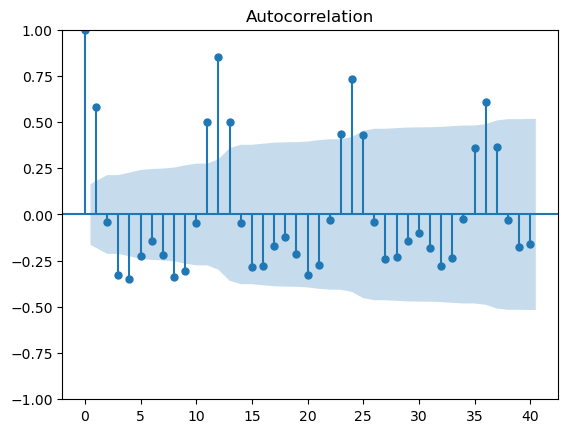

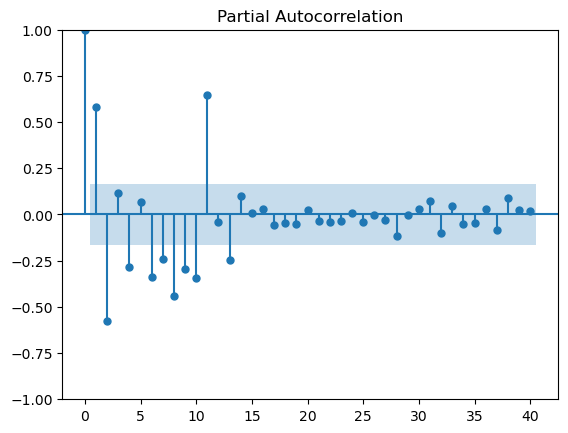

In [47]:
from statsmodels.tsa.stattools import acf,pacf
import statsmodels.api as sm
fig = sm.graphics.tsa.plot_acf(diff,lags=40)
fig = sm.graphics.tsa.plot_pacf(diff,lags=40)

**From ACF curve, optimal vale of q in the ARIMA model must be 1**
**From PACF curve, optimal value q in the ARIMA model is 1**

# Train-test Split
**Split the data into train (80%) & test (20%)**

 - for time series data, we have use first 80% of records for training & next 20% of records for testing
 - here 80% = 0.8*142 = 114 records. so first we have to use for training

**Note: We should not apply train-test split function because it divide the data randomly**

In [48]:
y_train = diff[:114]
y_test = diff[114:]

# Build ARIMA Model
**ARIMA model is build by using p,d,q values**

 1. p is AR value (determined from PACF plot)
 2. d is intergration
 3. q is MA value (determined from ACF)


**Modelling** 

In [49]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(diff, order=(1,2,1))
ARIMA = model.fit()

### **Prediction**

In [57]:
ypred_test = ARIMA.predict(start=y_test.index[0], end=y_test.index[-1])
ypred_train = ARIMA.predict(start=y_train.index[0], end=y_train.index[-1])

### **Evalution**

In [58]:
from sklearn.metrics import r2_score
print('Train R2',r2_score(ypred_train,y_train))
print('Test R2',r2_score(ypred_test,y_test))

Train R2 -0.11845073949801233
Test R2 0.0668302499551574


**Here, ARIMA model is not performing well, because there is seasonality in the given data**

# Build SARIMAX Model
**Whenever, there is seasonality in given data, apply SARIMAX**

**SARIMAX model is build by using p,d,q,s values**F)

In [59]:
#Modelling
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(diff,seasonal_order=(1,2,1,12))
SARIMAX = model.fit()

In [60]:
#Prediction
ypred_train = SARIMAX.predict(start=y_train.index[0], end=y_train.index[-1])
ypred_test = SARIMAX.predict(start=y_test.index[0], end=y_test.index[-1])

In [62]:
#Evalution
from sklearn.metrics import r2_score
print('Train R2 of SARIMAX model:',r2_score(ypred_train,y_train))
print('Train R2 of SARIMAX model:',r2_score(ypred_test,y_test))

Train R2 of SARIMAX model: -1.2483523086043298
Train R2 of SARIMAX model: -1.0466943651537974
